> Assign -1 for similarity if there is missing in either of the Fields 
(No additional columns)

In [1]:
import pandas as pd
import numpy as np
import libact
from libact.models import SVM
from libact.query_strategies import QUIRE, UncertaintySampling, RandomSampling, ActiveLearningByLearning, HintSVM
import warnings
import matplotlib.pyplot as plt
from libact.models import SklearnAdapter
from sklearn import tree
import seaborn as sbn
import time
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
from Utils import *
from Similarity import *

- Get the Data

In [4]:
phone_path ='/Users/bengikoseoglu/Documents/Masters/Semester4/Thesis/Notebooks/1_Merging/phone_merged.csv'
phone_result=pd.read_csv(phone_path)
phone_result.head()

,Unnamed: 0,id_webpage,match,page_mpn,page_warc,page_color,page_url,page_phone_type,page_brand,page_product_type,page_rear_cam_resolution,page_product_code,page_memory,page_display_size,page_processor_type,page_computer_operating_system,page_display_resolution,page_ram,page_front_cam_resolution,page_dimensions,page_weight,page_width,page_depth,page_wattage,page_height,page_product_gtin,page_phone_carrier,page_manufacturer,page_body_material,page_modelnum,cat_product_gtin,cat_rear_cam_resolution,cat_memory,cat_phone_carrier,cat_ram,cat_height,cat_brand,cat_core_count,cat_wattage,cat_package_height,cat_product_code,cat_mpn,cat_voltage,cat_power_supply,cat_processor_type,cat_depth,cat_body_material,cat_weight,cat_phone_type,cat_display_resolution,cat_computer_operating_system,cat_manufacturer,cat_modelnum,cat_display_size,cat_width,cat_product_type,cat_dimensions,cat_front_cam_resolution,cat_color,prodcat_product_name,prodcat_id,id
0,0,node5fd6d025f29b89ff319c853d0e33744,0,NaN,ebay.com0.warc.nq.gz,gold on silver,http://www.ebay.com/itm/blocked-htc-one-m9-32g...,one m9,htc,smartphone,20.0mp,NaN,32gb,5 in,NaN,NaN,NaN,NaN,NaN,NaN,5.54 oz,2.74 in,0.38 in,2840mah,5.69 in.,NaN,t-mobile,NaN,NaN,NaN,00885909950997,8 mp,64gb,verizon wireless,1gb,5.4 in,apple,NaN,NaN,NaN,NaN,mg642ll/a,1810 mah,NaN,a8,0.3 in,"stainless steel, glass, anodized aluminum",4.5 oz,iphone 6,750 x 1334 pixels,ios 8,NaN,NaN,4.7 in,2.6 in,smartphone,138.1 x 67 x 6.9 mm,1.2 mp,space gray|silver|gold,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,db717f68-7a42-11e9-a70d-9a0011fd23e0
1,1,nodee9affe60fbe185b64feb5811d2e43159,0,htc6535lvw,ebay.com0.warc.nq.gz,gunmetal gray,http://www.ebay.com/itm/works-perfect-htc-one-...,m9,htc,smartphone,20 mp,NaN,32gb,5 in,NaN,NaN,NaN,NaN,NaN,NaN,5.54 oz,2.74 in,0.38 in,2840mah,5.69 in,NaN,verizon,NaN,NaN,NaN,00885909950997,8 mp,64gb,verizon wireless,1gb,5.4 in,apple,NaN,NaN,NaN,NaN,mg642ll/a,1810 mah,NaN,a8,0.3 in,"stainless steel, glass, anodized aluminum",4.5 oz,iphone 6,750 x 1334 pixels,ios 8,NaN,NaN,4.7 in,2.6 in,smartphone,138.1 x 67 x 6.9 mm,1.2 mp,space gray|silver|gold,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,db7181f2-7a42-11e9-a70d-9a0011fd23e0
2,2,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,0,6735a,ebay.com0.warc.nq.gz,gunmetal gray,http://www.ebay.com/itm/unlocked-htc-one-m9-32...,one m9,htc,smartphone,20 mp,NaN,32gb,5 in,NaN,NaN,NaN,NaN,NaN,NaN,5.54 oz,2.74 in,0.38 in,2840mah,5.69 in,821793045111,at&t,NaN,NaN,NaN,00885909950997,8 mp,64gb,verizon wireless,1gb,5.4 in,apple,NaN,NaN,NaN,NaN,mg642ll/a,1810 mah,NaN,a8,0.3 in,"stainless steel, glass, anodized aluminum",4.5 oz,iphone 6,750 x 1334 pixels,ios 8,NaN,NaN,4.7 in,2.6 in,smartphone,138.1 x 67 x 6.9 mm,1.2 mp,space gray|silver|gold,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,db71829c-7a42-11e9-a70d-9a0011fd23e0
3,3,node12b450a88f0d6b897758f676414c61,0,opja120,ebay.com0.warc.nq.gz,gold,http://www.ebay.com/itm/refurbished-htc-one-m9...,one m9,htc,NaN,NaN,NaN,32gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t-mobile,NaN,NaN,NaN,00885909950997,8 mp,64gb,verizon wireless,1gb,5.4 in,apple,NaN,NaN,NaN,NaN,mg642ll/a,1810 mah,NaN,a8,0.3 in,"stainless steel, glass, anodized aluminum",4.5 oz,iphone 6,750 x 1334 pixels,ios 8,NaN,NaN,4.7 in,2.6 in,smartphone,138.1 x 67 x 6.9 mm,1.2 mp,space gray|silver|gold,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,db7182d8-7a42-11e9-a70d-9a0011fd23e0
4,4,node9ace9d5daf49116fed3f11241dff6d,0,ebay_htconem932gbgoldonsilverunlocked,ebay.com0.warc.nq.gz,gold on silver,http://www.ebay.com/itm/nice-factory-unlocked-...,one m9,htc,smartphone,20 mp,NaN,32gb,5 in,NaN,android,NaN,NaN,NaN,NaN,5.54 oz,2.74 in,0.38 in,2840mah,5.69 in,NaN,unlocked,NaN,NaN,NaN,00885909950997,8 mp,64gb,verizon wireless,1gb,5.4 in,apple,NaN,NaN,NaN,NaN,mg642ll/a,1810 mah,NaN,a8,0.3 in,"stainless steel, glass, anodized aluminum",4.5 oz,iphone 6,750 x 1334 pixels,ios 8,NaN,NaN,4.7 in,2.6 in,smartphone,138.1 x 67 x 6.9 mm,1.2 mp,space gray|silver|gold,ipho

In [5]:
phone_result.shape

(21455, 62)

- Look at missing values

In [6]:
no_unq=[len(phone_result[i].unique()) for i in list(phone_result.columns)]

In [7]:
df=pd.DataFrame(phone_result.isna().sum())
df['no_unique_values']=no_unq
df['percent_mis']=df[0]/phone_result.shape[0]

In [8]:
df.sort_values(['percent_mis'])

,0,no_unique_values,percent_mis
Unnamed: 0,0,21455,0.000000
prodcat_product_name,0,48,0.000000
cat_product_type,0,5,0.000000
cat_width,0,14,0.000000
cat_display_size,0,15,0.000000
cat_computer_operating_system,0,23,0.000000
cat_display_resolution,0,14,0.000000
cat_phone_type,0,37,0.000000
cat_weight,0,31,0.000000
cat_depth,0,8,0.000000


In [9]:
phone_result.columns  

Index(['Unnamed: 0', 'id_webpage', 'match', 'page_mpn', 'page_warc',
       'page_color', 'page_url', 'page_phone_type', 'page_brand',
       'page_product_type', 'page_rear_cam_resolution', 'page_product_code',
       'page_memory', 'page_display_size', 'page_processor_type',
       'page_computer_operating_system', 'page_display_resolution', 'page_ram',
       'page_front_cam_resolution', 'page_dimensions', 'page_weight',
       'page_width', 'page_depth', 'page_wattage', 'page_height',
       'page_product_gtin', 'page_phone_carrier', 'page_manufacturer',
       'page_body_material', 'page_modelnum', 'cat_product_gtin',
       'cat_rear_cam_resolution', 'cat_memory', 'cat_phone_carrier', 'cat_ram',
       'cat_height', 'cat_brand', 'cat_core_count', 'cat_wattage',
       'cat_package_height', 'cat_product_code', 'cat_mpn', 'cat_voltage',
       'cat_power_supply', 'cat_processor_type', 'cat_depth',
       'cat_body_material', 'cat_weight', 'cat_phone_type',
       'cat_display_resol

- Drop full missing columns from the datafarame, and their correpondence in page and category

In [10]:
full_missing_columns=list(df[df['percent_mis']==1].index)
full_missing_columns

['cat_wattage',
 'cat_package_height',
 'cat_product_code',
 'cat_power_supply',
 'cat_manufacturer',
 'cat_modelnum']

In [11]:
only_one_value_cols=list(df[df['no_unique_values']==1].index)
only_one_value_cols

['cat_wattage',
 'cat_package_height',
 'cat_product_code',
 'cat_power_supply',
 'cat_manufacturer',
 'cat_modelnum']

In [12]:
page_col_drop=['page_'+i[4:] for i in full_missing_columns]
cat_col_drop=['cat_'+i[4:] for i in full_missing_columns]
cat_col_drop.extend(page_col_drop)

In [13]:
# check whether every column exists
df_columns=list(phone_result.columns)
new_drop=[]
for i in cat_col_drop:
    if(i in df_columns):
        new_drop.append(i)
new_drop

['cat_wattage',
 'cat_package_height',
 'cat_product_code',
 'cat_power_supply',
 'cat_manufacturer',
 'cat_modelnum',
 'page_wattage',
 'page_product_code',
 'page_manufacturer',
 'page_modelnum']

In [14]:
phone_result=phone_result.drop(new_drop,axis=1)

In [15]:
## not usable:
# Unnamed: 0
# id_webpage
# prodcat_id
# page_url
# page_warc 
# prodcat_product_name

# match

## no matches: 
# cat_voltage
# cat_package_height
# cat_core_count
# cat_power_supply

# page_product_type -> cat_product_type
# page_mpn -> cat_mpn
# page_brand -> cat_brand
# page_phone_type -> cat_product_type
# page_computer_operating_system -> cat_computer_operating_system
# page_memory -> cat_memory
# page_depth -> cat_depth
# page_product_grin -> cat_product_gtin
# page_rear_cam_resolution -> cat_rear_cam_resolution
# page_height -> cat_height
# page_phone_carrier -> cat_phone_carrier
# page_ram -> cat_ram
# page_dimensions -> cat_dimensions
# page_front_cam_resolution -> cat_front_cam_resolution
# page_body_material -> cat_body_material
# page_color -> cat_color
# page_display_size -> cat_display_size
# page_processor_type -> cat_processor_type
# page_weight -> cat_weight
# page_display_resolution -> cat_display_resolution
# page_width -> cat_width

# page_wattage -> cat_wattage (MISSING)
# page_product_code -> cat_product_code (MISSING)
# page_manufacturer -> cat_manufacturer (MISSING)
# page_modelnum -> cat_modelnum. (MISSING)


- Assign 0 for similarity if there is missing in either of the Fields

In [16]:
df2=phone_result[['page_product_type','cat_product_type','page_mpn','cat_mpn','page_brand','cat_brand','page_phone_type','cat_phone_type',
  'page_computer_operating_system','cat_computer_operating_system','page_memory','cat_memory','page_depth','cat_depth',
  'page_product_gtin','cat_product_gtin','page_rear_cam_resolution','cat_rear_cam_resolution',
  'page_height','cat_height','page_phone_carrier','cat_phone_carrier',
  'cat_ram','page_ram','page_dimensions','cat_dimensions','page_front_cam_resolution',
  'cat_front_cam_resolution','page_body_material','cat_body_material','page_color','cat_color',
    'page_display_size','cat_display_size','page_processor_type','cat_processor_type','page_weight','cat_weight','page_display_resolution',
    'cat_display_resolution','page_width','cat_width','match','id_webpage','prodcat_id']]
df2.head()

,page_product_type,cat_product_type,page_mpn,cat_mpn,page_brand,cat_brand,page_phone_type,cat_phone_type,page_computer_operating_system,cat_computer_operating_system,page_memory,cat_memory,page_depth,cat_depth,page_product_gtin,cat_product_gtin,page_rear_cam_resolution,cat_rear_cam_resolution,page_height,cat_height,page_phone_carrier,cat_phone_carrier,cat_ram,page_ram,page_dimensions,cat_dimensions,page_front_cam_resolution,cat_front_cam_resolution,page_body_material,cat_body_material,page_color,cat_color,page_display_size,cat_display_size,page_processor_type,cat_processor_type,page_weight,cat_weight,page_display_resolution,cat_display_resolution,page_width,cat_width,match,id_webpage,prodcat_id
0,smartphone,smartphone,NaN,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20.0mp,8 mp,5.69 in.,5.4 in,t-mobile,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gold on silver,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,node5fd6d025f29b89ff319c853d0e33744,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80
1,smartphone,smartphone,htc6535lvw,mg642ll/a,htc,apple,m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20 mp,8 mp,5.69 in,5.4 in,verizon,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gunmetal gray,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,nodee9affe60fbe185b64feb5811d2e43159,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80
2,smartphone,smartphone,6735a,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,821793045111,00885909950997,20 mp,8 mp,5.69 in,5.4 in,at&t,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gunmetal gray,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80
3,NaN,smartphone,opja120,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,NaN,0.3 in,NaN,00885909950997,NaN,8 mp,NaN,5.4 in,t-mobile,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gold,space gray|silver|gold,NaN,4.7 in,NaN,a8,NaN,4.5 oz,NaN,750 x 1334 pixels,NaN,2.6 in,0,node12b450a88f0d6b897758f676414c61,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80
4,smartphone,smartphone,ebay_htconem932gbgoldonsilverunlocked,mg642ll/a,htc,apple,one m9,iphone 6,android,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20 mp,8 mp,5.69 in,5.4 in,unlocked,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gold on silver,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,node9ace9d5daf49116fed3f11241dff6d,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80


In [17]:
df2.shape

(21455, 45)

- calculate similarities (jaccard, levenstein, jaro-winkler)

In [18]:
page_columns=get_clean_collist(df2, 'page')
cat_columns=get_clean_collist(df2, 'cat')
jac_columns=get_clean_collist(df2, 'jac')
lev_columns =get_clean_collist(df2, 'lev')
jaro_columns =get_clean_collist(df2, 'jaro')
p_result_nomiss=calculate_similarities_option4(df2,page_columns,cat_columns,jac_columns,lev_columns,jaro_columns)
p_result_nomiss.head()

,page_product_type,cat_product_type,page_mpn,cat_mpn,page_brand,cat_brand,page_phone_type,cat_phone_type,page_computer_operating_system,cat_computer_operating_system,page_memory,cat_memory,page_depth,cat_depth,page_product_gtin,cat_product_gtin,page_rear_cam_resolution,cat_rear_cam_resolution,page_height,cat_height,page_phone_carrier,cat_phone_carrier,cat_ram,page_ram,page_dimensions,cat_dimensions,page_front_cam_resolution,cat_front_cam_resolution,page_body_material,cat_body_material,page_color,cat_color,page_display_size,cat_display_size,page_processor_type,cat_processor_type,page_weight,cat_weight,page_display_resolution,cat_display_resolution,page_width,cat_width,match,id_webpage,prodcat_id,jac_product_type,lev_product_type,jaro_product_type,jac_mpn,lev_mpn,jaro_mpn,jac_brand,lev_brand,jaro_brand,jac_phone_type,lev_phone_type,jaro_phone_type,jac_computer_operating_system,lev_computer_operating_system,jaro_computer_operating_system,jac_memory,lev_memory,jaro_memory,jac_depth,lev_depth,jaro_depth,jac_product_gtin,lev_product_gtin,jaro_product_gtin,jac_rear_cam_resolution,lev_rear_cam_resolution,jaro_rear_cam_resolution,jac_height,lev_height,jaro_height,jac_phone_carrier,lev_phone_carrier,jaro_phone_carrier,jac_ram,lev_ram,jaro_ram,jac_dimensions,lev_dimensions,jaro_dimensions,jac_front_cam_resolution,lev_front_cam_resolution,jaro_front_cam_resolution,jac_body_material,lev_body_material,jaro_body_material,jac_color,lev_color,jaro_color,jac_display_size,lev_display_size,jaro_display_size,jac_processor_type,lev_processor_type,jaro_processor_type,jac_weight,lev_weight,jaro_weight,jac_display_resolution,lev_display_resolution,jaro_display_resolution,jac_width,lev_width,jaro_width
0,smartphone,smartphone,NaN,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20.0mp,8 mp,5.69 in.,5.4 in,t-mobile,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gold on silver,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,node5fd6d025f29b89ff319c853d0e33744,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,1.0,1.0,1.0,-1.0,-1.000000,-1.000000,0.0,0.0,0.0,0.0,0.375,0.722222,-1.0,-1.0,-1.0,0.0,0.5,0.666667,0.333333,0.833333,0.955556,-1.0,-1.000000,-1.000000,0.000000,0.4,0.633333,0.333333,0.666667,0.84,0.0,0.2500,0.500000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.35,0.490476,0.333333,0.6,0.783333,-1.0,-1.0,-1.0,0.333333,0.666667,0.877778,-1.0,-1.0,-1.0,0.333333,0.666667,0.84
1,smartphone,smartphone,htc6535lvw,mg642ll/a,htc,apple,m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20 mp,8 mp,5.69 in,5.4 in,verizon,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gunmetal gray,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,nodee9affe60fbe185b64feb5811d2e43159,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,1.0,1.0,1.0,0.0,0.200000,0.483333,0.0,0.0,0.0,0.0,0.000,0.000000,-1.0,-1.0,-1.0,0.0,0.5,0.666667,0.333333,0.833333,0.955556,-1.0,-1.000000,-1.000000,0.333333,0.6,0.783333,0.333333,0.666667,0.84,0.5,0.4375,0.894531,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.20,0.565954,0.333333,0.6,0.783333,-1.0,-1.0,-1.0,0.333333,0.666667,0.877778,-1.0,-1.0,-1.0,0.333333,0.666667,0.84
2,smartphone,smartphone,6735a,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,821793045111,00885909950997,20 mp,8 mp,5.69 in,5.4 in,at&t,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gunmetal gray,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,1.0,1.0,1.0,0.0,0.250000,0.550000,0.0,0.0,0.0,0.0,0.375,0.722222,-1.0,-1.0,-1.0,0.0,0.5,0.666667,0.333333,0.833333,0.955556,0.0,0.142857,0.373016,0.333333,0.

- After calculating similarities, some columns might get the same value. So we are dropping them

In [19]:
jac_columns_el=eliminate_columns(p_result_nomiss,jac_columns)
lev_columns_el=eliminate_columns(p_result_nomiss,lev_columns)
jaro_columns_el=eliminate_columns(p_result_nomiss,jaro_columns)

- Calculate heat matrix between target and different string matching methods

In [20]:
corrmat = p_result_nomiss.corr()

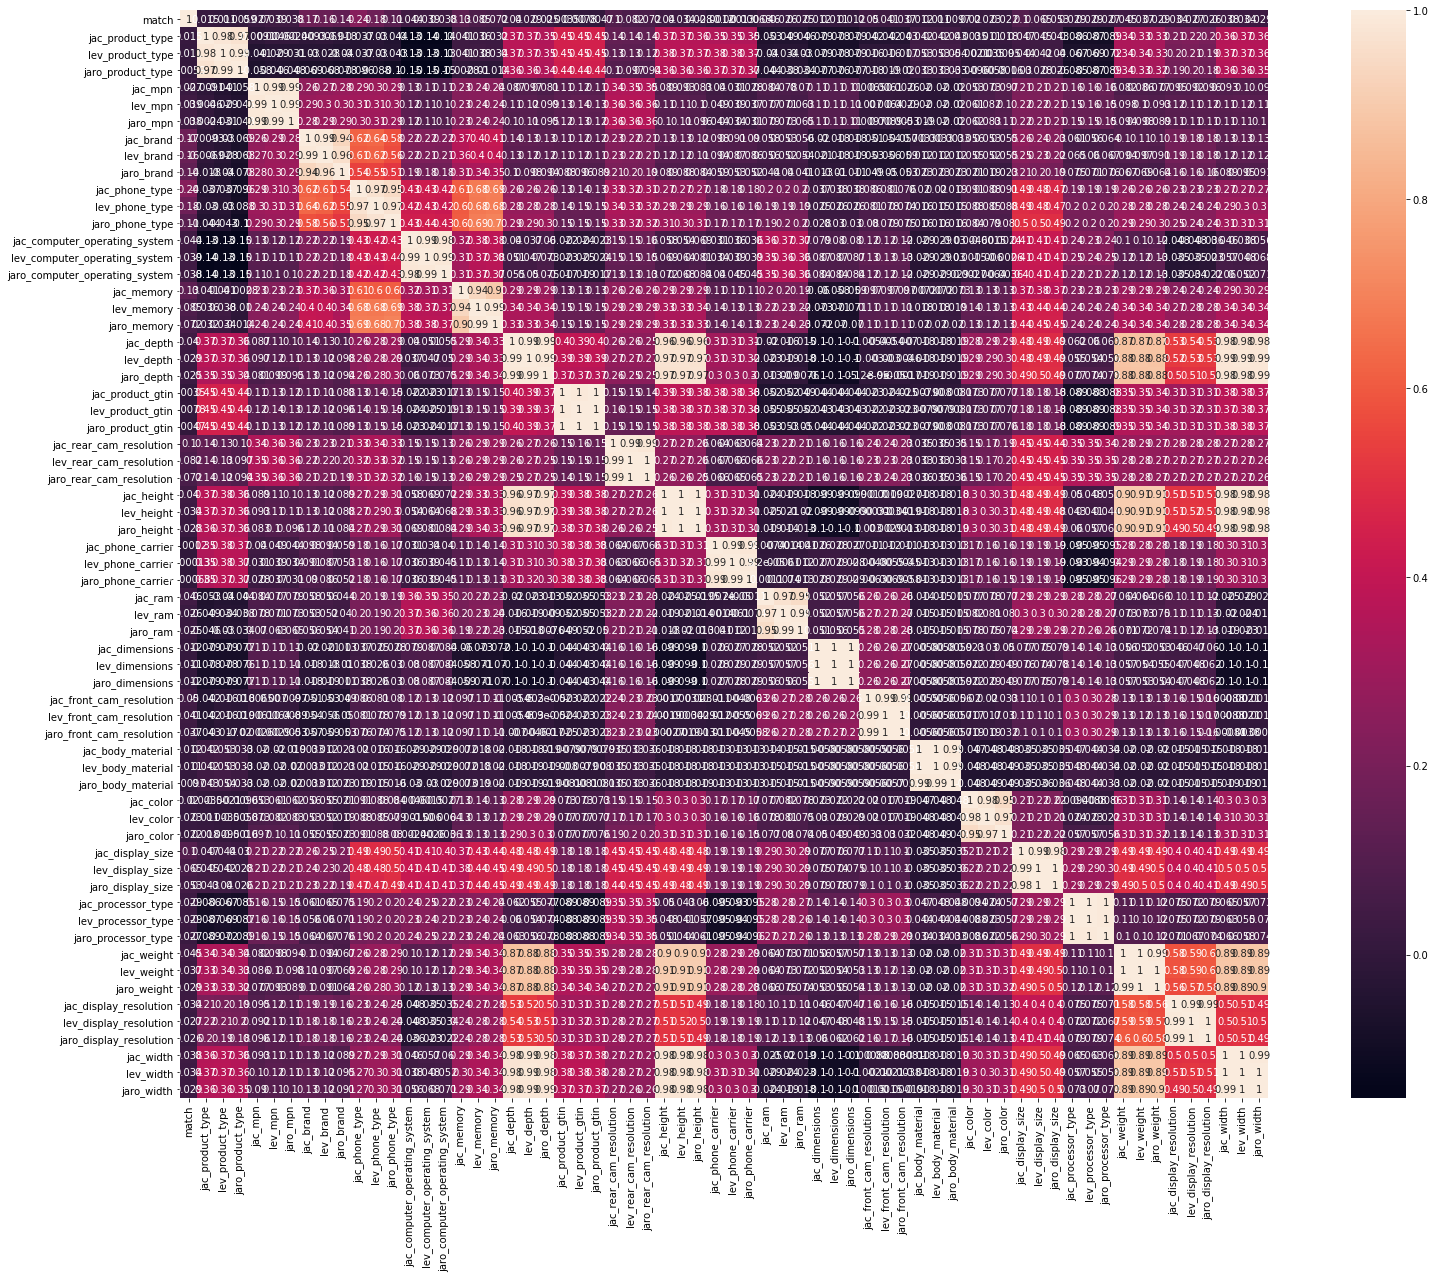

In [21]:
f, ax = plt.subplots(figsize=(30, 20))
sbn.heatmap(corrmat, vmax=1, cbar=True, annot=True, square=True)
plt.show()

# 1. USING ONLY JACCARD

- Modeling Parameters

In [22]:
cols= jac_columns_el.copy()
# this time include missing columns as well
cols.append('match')
p_result_nomiss_jac=df2[cols]
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)

# we start with 10 labeled instances, make the other instances 'None'
seed=10
samp=get_seed_random(y_train,10)

# the data needs to be in Dataset class
# we have 10 labeled instances, make the other instances 'None'
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)

# number of samples to query, normally you would like to query until you use all the training
quota = len(y_train) - seed
#quota=200

In [23]:
p_result_nomiss_jac.head()

,jac_product_type,jac_mpn,jac_brand,jac_phone_type,jac_computer_operating_system,jac_memory,jac_depth,jac_product_gtin,jac_rear_cam_resolution,jac_height,jac_phone_carrier,jac_ram,jac_dimensions,jac_front_cam_resolution,jac_body_material,jac_color,jac_display_size,jac_processor_type,jac_weight,jac_display_resolution,jac_width,match
0,1.0,-1.0,0.0,0.0,-1.0,0.0,0.333333,-1.0,0.000000,0.333333,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.333333,-1.0,0.333333,-1.0,0.333333,0
1,1.0,0.0,0.0,0.0,-1.0,0.0,0.333333,-1.0,0.333333,0.333333,0.5,-1.0,-1.0,-1.0,-1.0,0.0,0.333333,-1.0,0.333333,-1.0,0.333333,0
2,1.0,0.0,0.0,0.0,-1.0,0.0,0.333333,0.0,0.333333,0.333333,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.333333,-1.0,0.333333,-1.0,0.333333,0
3,-1.0,0.0,0.0,0.0,-1.0,0.0,-1.000000,-1.0,-1.000000,-1.000000,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,-1.0,0.333333,0.333333,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.333333,-1.0,0.333333,-1.0,0.333333,0


- Model results (pure)

In [24]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.5964912280701754
7001
10
36
34


In [25]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.20512820512820512
7011
0
62
8


In [26]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.6865671641791045
6993
18
24
46


## 1.1. Uncertainity Sampling

### 1.1.1. Logistic Regression

- Run 1

In [27]:
run_=1

start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_opt4_onlyjac_uncertainity_log_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q, iter_, f1score, tn, fp,fn, tp, k, trn_dss, label_holder, asked_id = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5964912280701754
Current progress: 100.0 %
2793.7102489471436


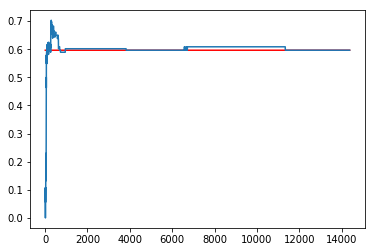

In [28]:
plt.plot(q, [f1_score_log] * (len(q)), '-r')
plt.plot(q, f1score)

- Run 10

In [29]:
run_=10

start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_opt4_onlyjac_uncertainity_log_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_10, iter_10, f1score_10, tn, fp,fn, tp, k, trn_dss, label_holder, asked_id = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5964912280701754
Current progress: 100.0 %
1177.0493280887604


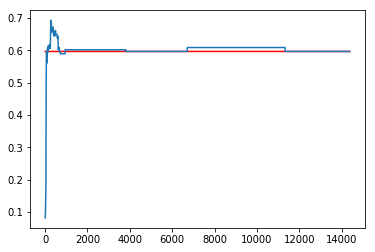

In [30]:
plt.plot(q_10, [f1_score_log] * (len(q_10)), '-r')
plt.plot(q_10, f1score_10)

- Run 20

In [31]:
run_=20

start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_opt4_onlyjac_uncertainity_log_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_20, iter_20, f1score_20, tn, fp,fn, tp, k, trn_dss, label_holder, asked_id = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5964912280701754
Current progress: 100.0 %
1120.2681369781494


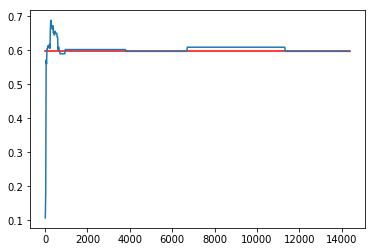

In [34]:
plt.plot(q_20, [f1_score_log] * (len(q_20)), '-r')
plt.plot(q_20, f1score_20)

- Run 50

In [33]:
run_=50

start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_opt4_onlyjac_uncertainity_log_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_50, iter_50, f1score_50, tn, fp,fn, tp, k, trn_dss, label_holder, asked_id = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5964912280701754
Current progress: 100.0 %
1029.4027512073517


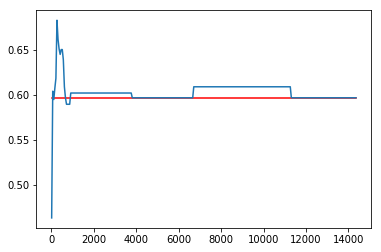

In [35]:
plt.plot(q_50, [f1_score_log] * (len(q_50)), '-r')
plt.plot(q_50, f1score_50)

- run 100

In [36]:
run_=100

start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_opt4_onlyjac_uncertainity_log_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_100, iter_100, f1score_100, tn, fp,fn, tp, k, trn_dss, label_holder, asked_id = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5964912280701754
Current progress: 100.0 %
1226.875356912613


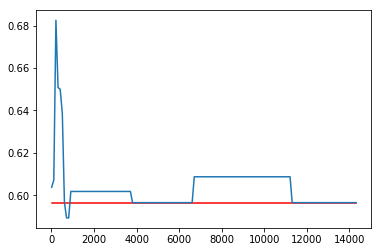

In [38]:
plt.plot(q_100, [f1_score_log] * (len(q_100)), '-r')
plt.plot(q_100, f1score_100)